---
title: "sliding window"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

This is the temperature for the Yatir Forest, between 2 and 5 of January 2022.
Data (<a href="shani_2022_january.csv" download>download .csv here</a>) is in intervals of 10 minutes, and was downloaded from the Israel Meteorological Service.

In [11]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.ticker as ticker
import os
import warnings
import scipy
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters
# %matplotlib widget

In [2]:
#| code-summary: "define useful functions"
# dirty trick to have dates in the middle of the 24-hour period
# make minor ticks in the middle, put the labels there!
# from https://matplotlib.org/stable/gallery/ticks/centered_ticklabels.html

def centered_dates(ax):
    date_form = DateFormatter("%d %b")  # %d 3-letter-Month
    # major ticks at midnight, every day
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    # minor ticks at noon, every day
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    # erase major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    # set minor tick labels as define above
    ax.xaxis.set_minor_formatter(date_form)
    # completely erase minor ticks, center tick labels
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

In [3]:
#| code-summary: "load data"
df = pd.read_csv('shani_2022_january.csv', parse_dates=['date'], index_col='date')

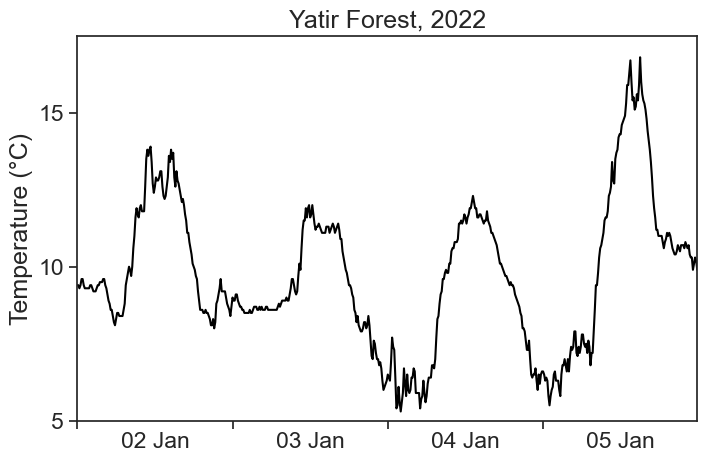

In [4]:
#| code-summary: "plot temperature data"
fig, ax = plt.subplots(figsize=(8,5))
start = "2022-01-02"
end = "2022-01-05"
df = df.loc[start:end]
ax.plot(df['TD'], color='black')

plot_settings = {
    'ylim': [5, 17.5],
    'xlim': [df.index[0], df.index[-1]],
    'ylabel': "Temperature (°C)",
    'title': "Yatir Forest, 2022",
    'yticks': [5, 10, 15]
}

ax.set(**plot_settings)
centered_dates(ax)

We see that the temperature curve has a rough profile.
Can we find ways of getting smoother curves?

## convolution

Convolution is a fancy word for averaging a time series using a sliding window.
We will use the terms **convolution, running average, and rolling average** interchangeably. 
See the animation below.
We take all temperature values inside a window of width 500 minutes (51 points), and average them with equal weights.
The weights profile is called `kernel`.

<div style="display: flex; justify-content: center;">
<iframe width="650" height="366" src="https://www.youtube.com/embed/SkrpjS0F6CE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</div>

The pink curve is much smoother than the original!
However, the running average cannot describe sharp temperature changes.
If we decrease the window width to 200 minutes (21 points), we get the following result.

<div style="display: flex; justify-content: center;">
<iframe width="650" height="366" src="https://www.youtube.com/embed/frgRh1c0740" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</div>

There is a tradeoff between the smoothness of a curve, and its ability to describe sharp temporal changes.

## kernels

We can modify our running average, so that values closer to the center of the window have higher weights, and those further away count less.
This is achieved by changing the weight profile, or the shape of the kernel.
We see below the result of a running average using a triangular window of base 500 minutes (51 points).

<div style="display: flex; justify-content: center;">
<iframe width="650" height="366" src="https://www.youtube.com/embed/VOhs01jeQZU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</div>

Things can get as fancy as we want.
Instead of a triangular kernel, which has sharp edges, we can choose a smoother gaussian kernel, see the difference below.
We used a gaussian kernel with 60-minute standard deviation.

<div style="display: flex; justify-content: center;">
<iframe width="650" height="366" src="https://www.youtube.com/embed/3py9WwQWk1A" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</div>

See how the three kernel shapes compare. There are [*many* kernels to chose from](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows){target="_blank"}.
![](kernel_shapes.png)

## math

The definition of a convolution between signal $f(t)$ and kernel $k(t)$ is

$$
(f * k)(t) = \int f(\tau)k(t-\tau)d\tau.
$$

The expression $f*k$ denotes the convolution of these two functions.
The argument of $k$ is $t-\tau$, meaning that the kernel runs from left to right (as $t$ does), and at every point the two signals ($f$ and $k$) are multiplied together.
It is the product of the signal with the weight function $k$ that gives us an average.
Because of $-\tau$, the kernel is flipped backwards, but this has no effect to symmetric kernels, like to ones in the examples above.
Finally, the actual running average is not the convolution, but

$$
\frac{(f * k)(t)}{\displaystyle \int k(t)dt}.
$$

Whenever the integral of the kernel is 1, then the convolution will be identical with the running average.


## numerics

Running averages are very common tools in time-series analysis.
The `pandas` package makes life quite simple.
For example, in order to calculate the running average of temperature using a rectangular kernel, one writes:

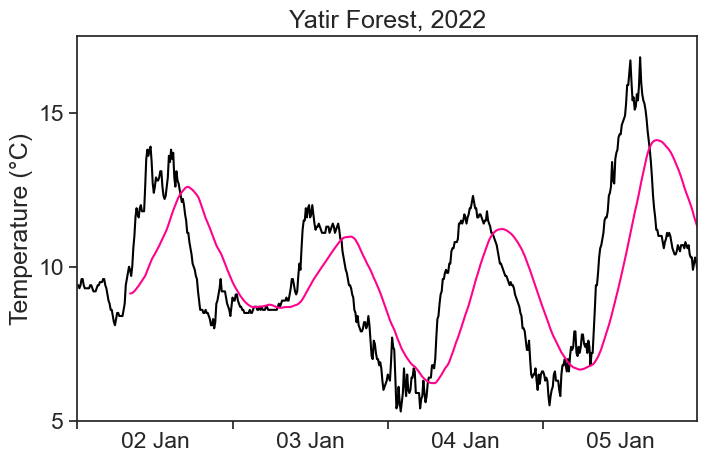

In [5]:
#| code-fold: false
df['temp_smoothed'] = (
                       df['TD'].rolling(window='500min',
                                        min_periods=50   # comment this to see what happens
                                        )
                               .mean()
                      )

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df['TD'], color='black')
ax.plot(df['temp_smoothed'], color='xkcd:hot pink')
ax.set(**plot_settings)
centered_dates(ax)

The pink curve looks smooth, but why does it lag behind the data?! What's going on?

### 7-day average of COVID-19 infections

During the COVID-19 pandemic, we would see graphs like this all the time in the news:

In [6]:
#| code-summary: "import COVID-19 data for Israel, process it"
# data from https://health.google.com/covid-19/open-data/raw-data?loc=IL
# define the local file path
local_file_path = 'COVID_19_israel.csv'
# check if the local file exists
if os.path.exists(local_file_path):
    # if the local file exists, load it
    covid_IL = pd.read_csv(local_file_path, parse_dates=['date'], index_col='date')
else:
    # if the local file doesn't exist, download from the URL
    url = "https://storage.googleapis.com/covid19-open-data/v3/location/IL.csv"
    covid_IL = pd.read_csv(url, parse_dates=['date'], index_col='date')
    # save the downloaded data to the local file for future use
    covid_IL.to_csv(local_file_path)

df_covid = covid_IL['new_confirmed'].to_frame()
df_covid['7d_avg'] = df_covid['new_confirmed'].rolling(window='7D').mean()

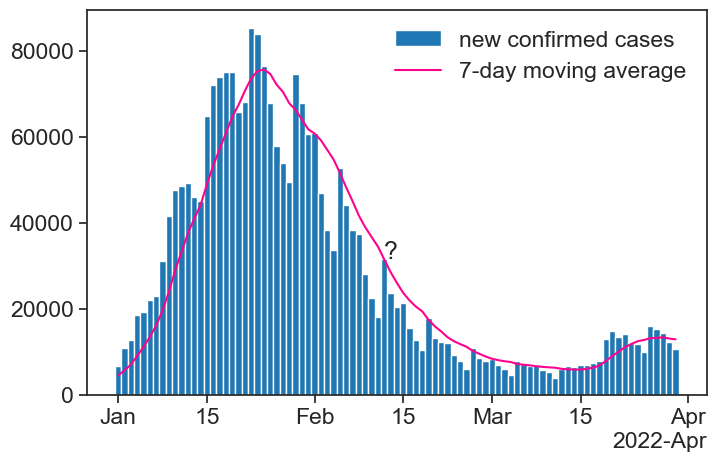

In [7]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8,5))
st = '2022-01-01'
en = '2022-03-30'
new_cases = ax.bar(df_covid[st:en].index, df_covid.loc[st:en,'new_confirmed'],
       color="tab:blue", width=1)
mov_avg, = ax.plot(df_covid.loc[st:en,'7d_avg'],
        color='xkcd:hot pink')
ax.legend(handles=[new_cases, mov_avg],
          labels=['new confirmed cases', '7-day moving average'],
          frameon=False)
weird_day = "2022-02-12"
weird_day_x = mdates.date2num(dt.datetime.strptime(weird_day, "%Y-%m-%d"))
ax.text(weird_day_x, df_covid.loc[weird_day,'new_confirmed'], "?")
# formating dates on x axis
locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

Take a look at the moving average next to the question mark. How can it be that high, when all the bars around that date are lower? Is the calculation right?

The answer is that the result of the moving average is assigned to the right-most date in the running window. This is reasonable for COVID-19 cases: for a given day, I can only calculate a 7-day average based on **past** values, I don't know what the future will be.

There is a simple way of assigning the result to the center of the window:

In [8]:
#| code-fold: false
df_covid['7d_avg_center'] = (
                             df_covid['new_confirmed']
                                 .rolling(window='7D',
                                          center=True)  # THIS
                                 .mean()
                            )

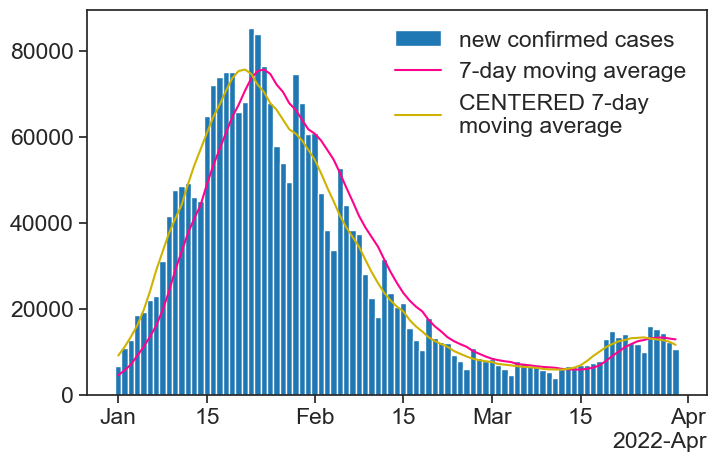

In [9]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8,5))
st = '2022-01-01'
en = '2022-03-30'
new_cases = ax.bar(df_covid[st:en].index, df_covid.loc[st:en,'new_confirmed'],
       color="tab:blue", width=1)
mov_avg, = ax.plot(df_covid.loc[st:en,'7d_avg'],
        color='xkcd:hot pink')
mov_avg_center, = ax.plot(df_covid.loc[st:en,'7d_avg_center'],
                          color='xkcd:mustard')
ax.legend(handles=[new_cases, mov_avg, mov_avg_center],
          labels=['new confirmed cases',
                  '7-day moving average',
                  'CENTERED 7-day\nmoving average'],
          frameon=False)
# formating dates on x axis
locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

As a rule, we will used a **centered** moving average (`center=True`), unless stated otherwise.
Also, only use `min_periods` if you know what you are doing.

### gaussian

You can easily change the kernel shape by using the `win_type` argument. See how to perform a rolling mean with a gaussian kernel:

```python
(
df['temperature'].rolling(window=window_width,
                          center=True,
                          win_type="gaussian")
                 .mean(std=std_gaussian)
)
```

where

* `window_width` is an integer, number of points in your window
* `std_gaussian` is the standard deviation of your gaussian, **measured in sample points, not time!**

For instance, if we have measurements every 10 minutes, and our window width is 500 minutes, then `window_width = 500/10 + 1` (first and last included). If we want a standard deviation of 60 minutes, then `std_gaussian = 6`. The gaussian kernel will look like this:

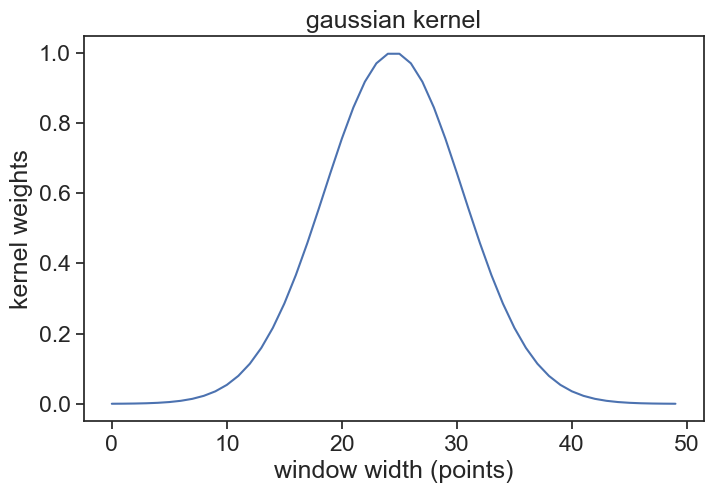

In [15]:
#| code-fold: false
window_width = 50  # in points = 500 min
std = 6  # in points = 60 min
fig, ax = plt.subplots(figsize=(8,5))
g = scipy.signal.gaussian(window_width, std)
ax.plot(g)
ax.set(xlabel="window width (points)",
       ylabel="kernel weights",
       title="gaussian kernel");

You can take a look at various options for kernel shapes [here](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows), provided by the `scipy` package.

### triangular

Same idea as gaussian, but simpler, because we don't need to think about standard deviation.

```python
(
df['temperature'].rolling(window=window_width,
                          center=True,
                          win_type="triang")
                 .mean()
)
```

## which window shape and width to choose?

🤷‍♂️

Sorry, there is not definite answer here... It really depends on your data and what you need to do with it.
See below a comparison of all examples in the videos above.

![](kernel_comparison.png)

One important question you need to ask is: what are the time scales associated with the processes I'm interested in? For example, if I'm interested in the daily temperature pattern, getting rid of 1-minute-long fluctuations would probably be ok. On the other hand, if we were to smooth the signal so much that all that can be seen are the temperature changes between summer and winter, then my smoothing got out of hand, and I threw away the very process I wanted to study.

All this is to say that you need to know in advance a few things about the system you are studying, otherwise you can't know what is "noise" that can be smoothed away.